# Capstone 2 - Exploratory Data Analysis (EDA)
* Notebook by Adam Lang, Springboard Data Science Fellow
* Date: 6/1/2024
* In this notebook we will focus on Exploratory Data Analysis (EDA).

# Background
* Two-dimensional (2D) ultrasound imaging is the gold standard for prenatal screening and fetal monitoring as it is low cost, non-invasive, real-time, and has no radiation hazards. The fetal head circumference (HC) can monitor fetal growth, estimate gestational age, and predict delivery methods for pregnant women. Therefore, fetal HC is one of the most important biological characteristics in prenatal ultrasounds. In current clinical practice, fetal HC measurements are performed manually by Sonographers which is not convenient, time-consuming, and heavily dependent on human skill and experience. However, an accurate measure of the fetal HC is not possible without precise detection of the fetal skull boundary which is often difficult in 2D ultrasound due to numerous imaging factors; all of which can lead to incomplete and incorrect detection of the fetal skull boundary and false measurements (Yang et al, 2022). It is also well known that the manual biometric measurements of the fetal head vary significantly by inter- and intra-observer variability and thus the concept of having a more accurate standard measuring system such as a computer vision algorithm could reduce the amount of time and variability because it would not be subject to intra-observer variability (van den Heuvel, 2018).
* Furthermore, in medically underserved areas of the U.S. and across the world, Medical Sonographers are not always available which is why companies like Google Health are leading the way in developing algorithms for ultrasound detection and measurement of the fetal head (BBC News, 2024). In addition, Ultimately, refining image detection algorithms for fetal ultrasound can help everyone involved in prenatal care whether they live in a big city or a rural underserved region. It is well known that 99% of maternal deaths worldwide occur in developing countries and enhancing the prenatal care before, during and after childbirth can and will save lives of countless women and newborns (van den Heuvel, 2018).
* In addition, ultrasound images are obtained following the same protocols in a repeatable way. Images should be acquired in a **specific plane to be useful for diagnosis, to decrease the inter- and intra-observer variability and to allow the measurement of specific structures**. Typically, more than 20 images are acquired for each ultrasound examination within mid-trimester screening ultrasound8. Occasionally, three dimensional (3D) images and videos can also be acquired to complete the clinical examination (Burgos-Artizzu et al. 2020).
* A fetal specialist will review the sonographers images and select those containing the anatomical structures of interest. Usually, trained research technicians, followed by a validation from a senior maternal-fetal expert, manually perform this task.
  * However, since each ultrasound examination usually contains more than 20 images (some hospitals almost as much as 60 at a time), this process is often slow, cumbersome and prone to errors.
  * This is why a well known landmark study looked at using computer vision neural networks like CNNs to detect the fetal plane to hopefully automate this task and reduce manual error (Burgos-Artizzu et al. 2020).

# Goals of the Project
* The original goal of this project was to utilize a dataset of 1,334 2D ultrasound images (999 training, 335 test) to perform standard deep learning computer vision tasks in object recognition: Image classification (fetal head vs. other), Image Classification Class Label for Gestation Age (GA): 1st trimester, 2nd trimester, 3rd trimester (although these measures are also closely related to the object segmentation task), Object detection (fetal head present), Object localization (skull boundary), and Object segmentation (fetal head measurements). The most basic level of success would be to have a positive prediction on each task mentioned.
* **However, the original dataset mentioned above with 1,334 2D images, is task specific for object segmentation of fetal head measurements. The dataset only contains labels of the predicted measurements of the fetal head circumference and it would be difficult to perform simple tasks such as object detection and classification using this dataset. Since object segmentation is one of the more difficult tasks in computer vision, I am going to start with a dataset that is more ideal for image classification. This dataset was published by Burgos-Artizzu et al. in 2020.**
  * It contains routinely acquired maternal-fetal screening ultrasound images collected from 2 different hospitals by several technicians and ultrasound devices.
  * All images were manually labeled by an expert maternal fetal clinicians.
  * **Images are divided into 6 classes**:
    * 4 of the most widely used fetal anatomical planes:
      * 1. Abdomen
      * 2. Brain
      * 3. Femur
      * 4. Thorax
    * In addition to these classes:
      * 5. Motherss cervix (widely used for prematurity screening) and
      * 6. A general category to include less common image planes.
    * Fetal brain images were further categorized into the 3 most common fetal brain planes:
      * 1. Trans-thalamic
      * 2. Trans-cerebellum
      * 3. Trans-ventricular
  * Metadata including patient number, us machine, device operator are also provided, as well as the train-test split used in the original paper.




# Data Source
The dataset information used for this Data Wrangling and Image Classification modeling is found here:
1. **Dataset source**: https://zenodo.org/records/3904280
2. **Github with additional datset info:** https://github.com/Yulv-git/Awesome-Ultrasound-Standard-Plane-Detection/tree/main
3. Original paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7311420/
  * Citation: Burgos-Artizzu XP, Coronado-Gutiérrez D, Valenzuela-Alcaraz B, Bonet-Carne E, Eixarch E, Crispi F, Gratacós E. Evaluation of deep convolutional neural networks for automatic classification of common maternal fetal ultrasound planes. Sci Rep. 2020 Jun 23;10(1):10200. doi: 10.1038/s41598-020-67076-5.

# Exploratory Data Analysis (EDA) - Overview + Background
* The steps for EDA in image processing and computer vision are slightly different for tabular than for text data.
* In the first notebook we focused on `Data Wrangling` which included:
	* Loading the data into labeled directories with the image classes.
	* Visualizing some of the images.
	* Image transformations.
	* Creating PyTorch Custom Dataset to process the images.
	* Getting our image data into PyTorch DataLoaders.
* Normally for medical image analysis we would want to perform EDA on the DICOM metadata using a Python library such as `pydicom`. However, the ultrasound images in this dataset are `.png` format and are not of DICOM format origin so there is no way to obtain the DICOM metadata.

# EDA Process - Details
* Here is the proposed process:
1. Get the data (again)
2. Organize images by label/class and train vs. test.
3. EDA on tabular metadata files - csv, xlsx
	* The dataset image labels/annotations are in the csv and excel files which are duplicate.
	* We will plot some of the data in the excel file to **demonstrate any class imbalances** that exist in the prediction labels/targets.
4. Image EDA - visualize some images
5. Pixel Size analysis for each class label in training data.
6. Transforms in PyTorch
	* Look again at the transforms and compressions in PyTorch.
7. Singular Value Decomposition (SVD)
		* very useful for image compression
		* Compare this to the PyTorch transforms.
		* Reconstruct images in each class of the training directory using SVD.

# 0. Import PyTorch and set up device agnostic code

In [1]:
## import libraries
import torch
from torch import nn

## check the torch version
torch.__version__

'2.3.0+cu121'

We have Pytorch version 2.3.0 and cu121

In [2]:
## let's setup device agnostic code -- important step in PyTorch workflow
device = "cuda" if torch.cuda.is_available() else "cpu"
#print device
device

'cpu'

Right now only cpu is available but we could run a GPU in google colab if needed, however not necessary for this first notebook as we won't be doing any modeling tasks.

In [3]:
## we can check the gpu we have available though with this line
#!nvidia-smi

# 1. Get the data!
* We will first get the data using `wget` call to github.




In [3]:
import os
import requests
import zipfile
from pathlib import Path
import pandas as pd
import shutil
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "FETAL_PLANES_ZENODO"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory already exists... skipping download")
else:
    print(f"{image_path} does not exist, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download
    with open(data_path / "FETAL_PLANES_ZENODO.zip", "wb") as f:
        request = requests.get('https://zenodo.org/record/3904280/files/FETAL_PLANES_ZENODO.zip?download=1')
        print("Downloading FETAL_PLANES_ZENODO data...")
        f.write(request.content)  # write content of request to file

    # Unzip the FETAL_PLANES_ZENODO data -- extracting all contents to image_path
    with zipfile.ZipFile(data_path / "FETAL_PLANES_ZENODO.zip", "r") as zip_ref:
        print("Unzipping FETAL_PLANES_ZENODO data...")
        zip_ref.extractall(image_path)

data/FETAL_PLANES_ZENODO does not exist, creating one...
Unzipping FETAL_PLANES_ZENODO data...


# 2. Create an organized image file directory

* The issue is if we choose to use the CustomDataSet class for handling multiple labels, we do not need to use the PyTorch ImageFolder class because ImageFolder is designed for simpler use cases where each image is associated with a **single label** based on its directory structure. The PyTorch CustomDataSet allows for more complex scenarios such as handling multiple labels
  * However, if we still wanted to leverage the organized directory structure created for ImageFolder while maintaining the ability to handle multiple labels, we would not be directly using the ImageFolder class. Instead, we would organize the data in a way that mimics what ImageFolder expects but then use the custom dataset class to load and transform the data accordingly.

Here's how you we will try to set up the code structure:

1. Organize Images by Class:
  * organize images into class-labeled directories.

2. Create a Custom Dataset Class:
  * This will allow us to handle the multiple label classification of the imaging data.

In [4]:
# Function to organize images by class
def organize_images_by_class(imgs_info, imgs_dir, x_col="Image_name", y_cols=["Plane", "Brain_plane"], seed=1, target_w=256, target_h=256):
    # Read the Excel file
    df = pd.read_excel(imgs_info, index_col=0, engine='openpyxl')
    df["Image_name"] = df.index
    df.reset_index(drop=True, inplace=True)
    df.rename(columns={'Train ': 'Train'}, inplace=True)

    # Adjust Image_name column to reflect correct paths in the Images folder
    df["Image_name"] = df["Image_name"].apply(lambda x: str(Path(imgs_dir) / "Images" / (x + ".png")))

    # Check if files with different extensions exist
    extensions = ['.png', '.jpg', '.jpeg']

    # Strip whitespace from class labels
    df["Plane"] = df["Plane"].str.strip()
    df["Brain_plane"] = df["Brain_plane"].str.strip()

    # Create directories for train and test sets directly under imgs_dir
    train_dir = Path(imgs_dir) / 'train_dir'
    test_dir = Path(imgs_dir) / 'test_dir'

    try:
        train_dir.mkdir(parents=True, exist_ok=True)
        test_dir.mkdir(parents=True, exist_ok=True)
        print(f"Created directories: {train_dir}, {test_dir}")
    except Exception as e:
        print(f"Error creating directories: {e}")

    # Create directories for each class
    plane_classes = df[y_cols[0]].unique()
    brain_plane_classes = df[y_cols[1]].unique()

    for cls in plane_classes:
        try:
            (train_dir / cls).mkdir(parents=True, exist_ok=True)
            (test_dir / cls).mkdir(parents=True, exist_ok=True)
        except Exception as e:
            print(f"Error creating class directory for {cls}: {e}")

    for cls in brain_plane_classes:
        try:
            (train_dir / cls).mkdir(parents=True, exist_ok=True)
            (test_dir / cls).mkdir(parents=True, exist_ok=True)
        except Exception as e:
            print(f"Error creating brain_plane directory for {cls}: {e}")

    # Split the DataFrame into train and test sets
    df_train = df[df["Train"] == 1].reset_index(drop=True)
    df_test = df[df["Train"] == 0].reset_index(drop=True)

    # Copy images to respective directories based on Plane and Brain_plane labels - this will move the images to their labeled directories
    for _, row in df_train.iterrows():
        image_base_path = Path(row["Image_name"])
        plane_label = row["Plane"]
        brain_plane_label = row["Brain_plane"]
        # Check if any file with the allowed extensions exists
        found = False
        for ext in extensions:
            image_path = image_base_path.with_suffix(ext)
            if image_path.exists():
                try:
                    shutil.copy(image_path, train_dir / plane_label / image_path.name)
                    shutil.copy(image_path, train_dir / brain_plane_label / image_path.name)
                    found = True
                    break
                except Exception as e:
                    print(f"Error copying {image_path} to {train_dir / plane_label}: {e}")
        if not found:
            print(f"Image file not found for {image_base_path} with any of extensions: {extensions}")

    for _, row in df_test.iterrows():
        image_base_path = Path(row["Image_name"])
        plane_label = row["Plane"]
        brain_plane_label = row["Brain_plane"]
        # Check if any file with the allowed extensions exists
        found = False
        for ext in extensions:
            image_path = image_base_path.with_suffix(ext)
            if image_path.exists():
                try:
                    shutil.copy(image_path, test_dir / plane_label / image_path.name)
                    shutil.copy(image_path, test_dir / brain_plane_label / image_path.name)
                    found = True
                    break
                except Exception as e:
                    print(f"Error copying {image_path} to {test_dir / plane_label}: {e}")
        if not found:
            print(f"Image file not found for {image_base_path} with any of extensions: {extensions}")

    print("Images have been organized by class.")

# Call the function with the appropriate arguments
path_to_labels = '/content/data/FETAL_PLANES_ZENODO/FETAL_PLANES_DB_data.xlsx'
organize_images_by_class(path_to_labels, str(image_path))


Created directories: data/FETAL_PLANES_ZENODO/train_dir, data/FETAL_PLANES_ZENODO/test_dir
Images have been organized by class.


### Now we will create a custom PyTorch Dataset class

In [5]:
import os
from typing import Tuple, List
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pathlib

class CustomDataSet(Dataset):
    def __init__(self, targ_dir: str, transform=None):
        self.targ_dir = pathlib.Path(targ_dir)
        self.transform = transform

        # Get all image paths
        self.paths = list(self.targ_dir.glob("*/*.png"))

        # Create class attributes
        self.classes = sorted(set(p.parent.name for p in self.paths))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

    def load_image(self, index: int) -> Image.Image:
        return Image.open(self.paths[index])

    def __len__(self) -> int:
        return len(self.paths)

    def __getitem__(self, index: int) -> Tuple[Image.Image, int]:
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]

        if self.transform:
            img = self.transform(img)

        return img, class_idx

#### Let's look at some of the dataset directories we created.

In [6]:
import os

## function to iterate through the image data directories
def walk_through_dir(dir_path):
  """Iterates through dir_paths returning its contents"""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

In [7]:
## look at image directories now
walk_through_dir(image_path)

There are 3 directories and 3 images in 'data/FETAL_PLANES_ZENODO'
There are 10 directories and 0 images in 'data/FETAL_PLANES_ZENODO/test_dir'
There are 0 directories and 1678 images in 'data/FETAL_PLANES_ZENODO/test_dir/Other'
There are 0 directories and 645 images in 'data/FETAL_PLANES_ZENODO/test_dir/Maternal cervix'
There are 0 directories and 660 images in 'data/FETAL_PLANES_ZENODO/test_dir/Fetal thorax'
There are 0 directories and 1472 images in 'data/FETAL_PLANES_ZENODO/test_dir/Fetal brain'
There are 0 directories and 339 images in 'data/FETAL_PLANES_ZENODO/test_dir/Trans-cerebellum'
There are 0 directories and 358 images in 'data/FETAL_PLANES_ZENODO/test_dir/Fetal abdomen'
There are 0 directories and 524 images in 'data/FETAL_PLANES_ZENODO/test_dir/Fetal femur'
There are 0 directories and 3799 images in 'data/FETAL_PLANES_ZENODO/test_dir/Not A Brain'
There are 0 directories and 765 images in 'data/FETAL_PLANES_ZENODO/test_dir/Trans-thalamic'
There are 0 directories and 302 im

Great we can see the image directories we created.

In [8]:
## setup the train and test directory paths
# Define the paths to the train and test directories
train_dir = image_path / 'train_dir'
test_dir = image_path / 'test_dir'

# print train and test dirs
train_dir, test_dir

(PosixPath('data/FETAL_PLANES_ZENODO/train_dir'),
 PosixPath('data/FETAL_PLANES_ZENODO/test_dir'))

# 3. Exploratory Data Analysis (EDA) on tabular dataset

* The dataset comes with a csv and excel file (both are the same) with the image labels.
* We will take a closer look at the data labels for class imbalances in the target prediction variables.

In [9]:
import pandas as pd

## load the data into a dataframe
df_excel = pd.read_excel('/content/data/FETAL_PLANES_ZENODO/FETAL_PLANES_DB_data.xlsx')

# head
df_excel.head()

,Image_name,Patient_num,Plane,Brain_plane,Operator,US_Machine,Train
0,Patient00001_Plane1_1_of_15,1,Other,Not A Brain,Other,Aloka,1
1,Patient00001_Plane1_2_of_15,1,Other,Not A Brain,Other,Aloka,1
2,Patient00001_Plane1_3_of_15,1,Other,Not A Brain,Other,Aloka,1
3,Patient00001_Plane1_4_of_15,1,Other,Not A Brain,Other,Aloka,1
4,Patient00001_Plane1_5_of_15,1,Other,Not A Brain,Other,Aloka,1


In [10]:
## info on the data
df_excel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12400 entries, 0 to 12399
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Image_name   12400 non-null  object
 1   Patient_num  12400 non-null  int64 
 2   Plane        12400 non-null  object
 3   Brain_plane  12400 non-null  object
 4   Operator     12400 non-null  object
 5   US_Machine   12400 non-null  object
 6   Train        12400 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 678.2+ KB


In [11]:
## check for null values
df_excel.isna().sum()

Image_name     0
Patient_num    0
Plane          0
Brain_plane    0
Operator       0
US_Machine     0
Train          0
dtype: int64

No null values in the dataset, this will be very helpful for EDA.

In [12]:
## check dtypes
df_excel.dtypes

Image_name     object
Patient_num     int64
Plane          object
Brain_plane    object
Operator       object
US_Machine     object
Train           int64
dtype: object

In [13]:
## columns
df_excel.columns

Index(['Image_name', 'Patient_num', 'Plane', 'Brain_plane', 'Operator',
       'US_Machine', 'Train '],
      dtype='object')

In [14]:
## lets look at the Train column value_counts()
df_excel['Train '].value_counts()

Train 
1    7129
0    5271
Name: count, dtype: int64

Based on the metadata we have from the dataset source, we know that 1 is Train and 0 is test.

## Evaluate Train vs. Test data percentages

In [15]:
## lets calculate the number of train and test images based off this
7129 + 5271

12400

In [16]:
## Let's calculate the % of the train and test data
train_count = 7129
test_count = 5217
total_count = 12400
train_percentage = (train_count / total_count) * 100
test_percentage = (test_count / total_count) * 100

print(f"The percent of train data is: {train_percentage:.2f}%")
print('\n')
print(f"The percent of test data is: {test_percentage:.2f}%")

The percent of train data is: 57.49%


The percent of test data is: 42.07%


### Plot of the Train and Test Data Percentages

In [17]:
## Let's plot this
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [18]:
## df to plot
d = {'test_data': test_percentage,'train_data': train_percentage}
plot_df = pd.DataFrame(d,index=[0])
plot_df

,test_data,train_data
0,42.072581,57.491935


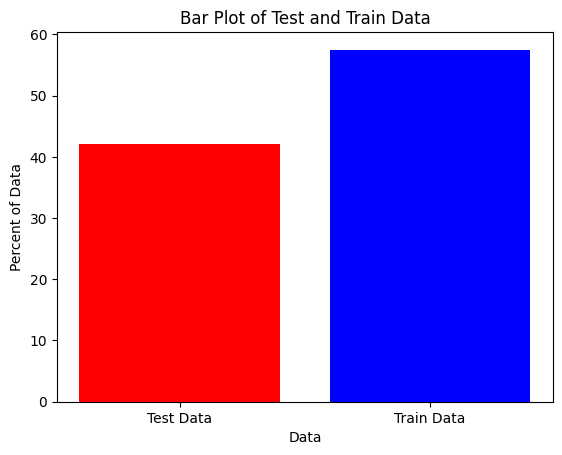

In [20]:
# Extract data from the dataframe
test_data = plot_df['test_data'].values[0]
train_data = plot_df['train_data'].values[0]

# Define bar labels
bar_labels = ['Test Data', 'Train Data']

# Define bar values
bar_values = [test_data, train_data]

# Create bar chart
plt.bar(bar_labels, bar_values,color=['red','blue'])

# Add title and axis labels
plt.title('Bar Plot of Test and Train Data')
plt.xlabel('Data')
plt.ylabel('Percent of Data')
plt.show();

Observations
* As we can see there is more train data (57%) than test data (42%).

## Evaluate the Target labels/classes value counts - is there imbalance?

In [21]:
## we can see the value_counts of some columns of importance: Plane
df_excel['Plane'].value_counts().sort_values(ascending=False)

Plane
Other              4213
Fetal brain        3092
Fetal thorax       1718
Maternal cervix    1626
Fetal femur        1040
Fetal abdomen       711
Name: count, dtype: int64

Observations:
* It appears the class label "Other" dominates the dataset, followed closely by "Fetal Brain".
* The "Fetal Abdomen" class has the least amount of images.
* We can explore this further in the next EDA notebook, but with image augmentation we can perhaps augment the fact that there is class imbalance. We also have to be aware that the model we build in future notebooks could overfit the data and predict "Other or "Fetal Brain" simply due to class imbalance. Something to think about during the next steps in EDA and pre-processing.

## Plot of the Plane Classes - is there imbalance?

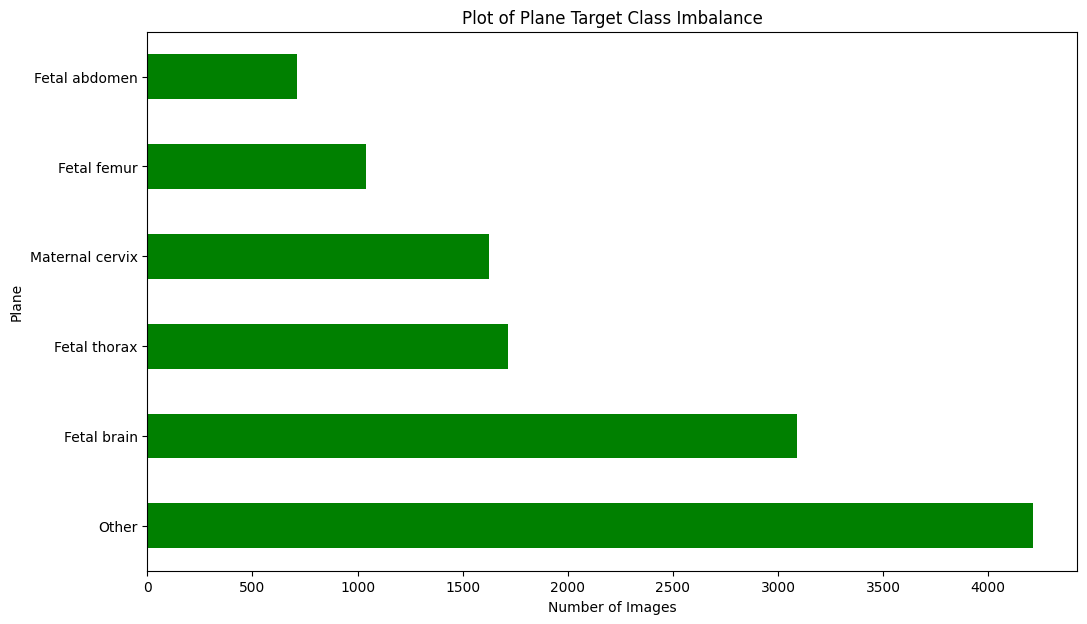

In [26]:
#plot the plane classes
plt.figure(figsize=(12,7))
df_excel['Plane'].value_counts().plot(kind='barh',color='green')
plt.title('Plot of Plane Target Class Imbalance')
plt.xlabel('Number of Images')
plt.show();

Observations
* We can see there is imbalance in these classes as I mentioned above.
* "Other" dominates more than the othe classes with more than 2x the number of image samples in the dataset than Fetal thorax and Maternal Cervix and almost 4x more image samples than fetal abdomen and fetal femur.
* The next closest class in samples is fetal brain.
* As I mentioned above, we may need to utilize data augmentation of the images using augmented transformations so that we do not create an overfitted model that generalizes poorly on unseen or validation data for the aformentioned image classes.

## Evaluate `Brain_plane` target classes - is there imbalance?

In [23]:
## we can see the value_counts of the Brain_plane
df_excel['Brain_plane'].value_counts().sort_values(ascending=False)

Brain_plane
Not A Brain          9308
Trans-thalamic       1638
Trans-cerebellum      714
Trans-ventricular     597
Other                 143
Name: count, dtype: int64

Observations
* Interestingly enough, there are more "Brain_plane" class members for "Not A Brain" than for actual planes of the brain.
* Again this is something we may have to explore further with image data augmentation in the pre-processing steps to building our model.
* This certainly could overfit the model to predict "Not A Brain" rather than a plane of the brain.

### Plot `Brain_plane` target classes - is there imbalance?

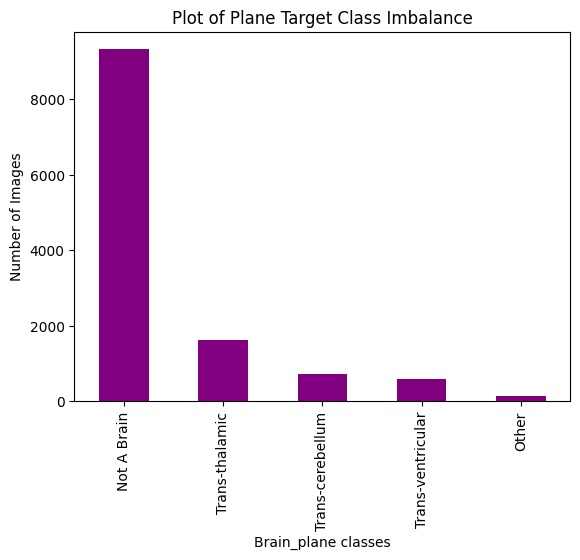

In [27]:
## plot Brain_plane target classes
df_excel['Brain_plane'].value_counts().plot(kind='bar',color='purple')
plt.title('Plot of Plane Target Class Imbalance')
plt.xlabel('Brain_plane classes')
plt.ylabel('Number of Images')
plt.show();

Observations
* Not a Brain is the dominant class brain plane.
* Again, we should utilize image augmentation techniques to help with the signficant class imbalance here so that the deep learning model will not generalize poorly on unseen data and not correctly predict one of the other brain planes.

# 4. Visualize an Image
* Here we will get all of the image paths, we will use glob to do this. The glob module, which is short for "global", is a function that's used to search for files that match a specific file pattern or name.
* We will pick a random image path using Python's random.choice() function.
* Then obtain the image class name using pathlib.Path.parent.stem
* Since we're working with images, we will open the image with Python's PIL (pillow) library
docs: https://pillow.readthedocs.io/en/stable/
* Finally we will show the image and print the metadata.

In [34]:
## first reminder of what image_path is
image_path

PosixPath('data/FETAL_PLANES_ZENODO')

Great! We can see random images in the image_path directory

In [36]:
import random
from PIL import Image

# set seed
#random.seed(42)

# 1. Get all image paths - glob (global path) -- or a "glob" of images
## */*/* will unpack anything in directory path
image_path_list = list(image_path.glob("*/*/*"))
image_path_list

[PosixPath('data/FETAL_PLANES_ZENODO/test_dir/Other/Patient01509_Plane1_8_of_13.png'),
 PosixPath('data/FETAL_PLANES_ZENODO/test_dir/Other/Patient01423_Plane1_2_of_2.png'),
 PosixPath('data/FETAL_PLANES_ZENODO/test_dir/Other/Patient01409_Plane1_10_of_27.png'),
 PosixPath('data/FETAL_PLANES_ZENODO/test_dir/Other/Patient01347_Plane1_7_of_24.png'),
 PosixPath('data/FETAL_PLANES_ZENODO/test_dir/Other/Patient01444_Plane3_7_of_7.png'),
 PosixPath('data/FETAL_PLANES_ZENODO/test_dir/Other/Patient01365_Plane1_7_of_17.png'),
 PosixPath('data/FETAL_PLANES_ZENODO/test_dir/Other/Patient01348_Plane1_4_of_8.png'),
 PosixPath('data/FETAL_PLANES_ZENODO/test_dir/Other/Patient01252_Plane1_8_of_17.png'),
 PosixPath('data/FETAL_PLANES_ZENODO/test_dir/Other/Patient01535_Plane1_12_of_21.png'),
 PosixPath('data/FETAL_PLANES_ZENODO/test_dir/Other/Patient01521_Plane1_1_of_1.png'),
 PosixPath('data/FETAL_PLANES_ZENODO/test_dir/Other/Patient01606_Plane1_18_of_18.png'),
 PosixPath('data/FETAL_PLANES_ZENODO/test_di

In [37]:
# 2. pick a random image_path
random_image_path = random.choice(image_path_list)
#print random image path
print(random_image_path)

data/FETAL_PLANES_ZENODO/test_dir/Fetal thorax/Patient01463_Plane6_2_of_5.png


In [38]:
# 3. Get an image class from path name (image class is name of directory where image is stored)
image_class = random_image_path.parent.stem

print(image_class)

Fetal thorax


Random image path: data/FETAL_PLANES_ZENODO/test_dir/Fetal thorax/Patient01463_Plane6_2_of_5.png
Image class: Fetal thorax
Image height: 496
Image width: 959


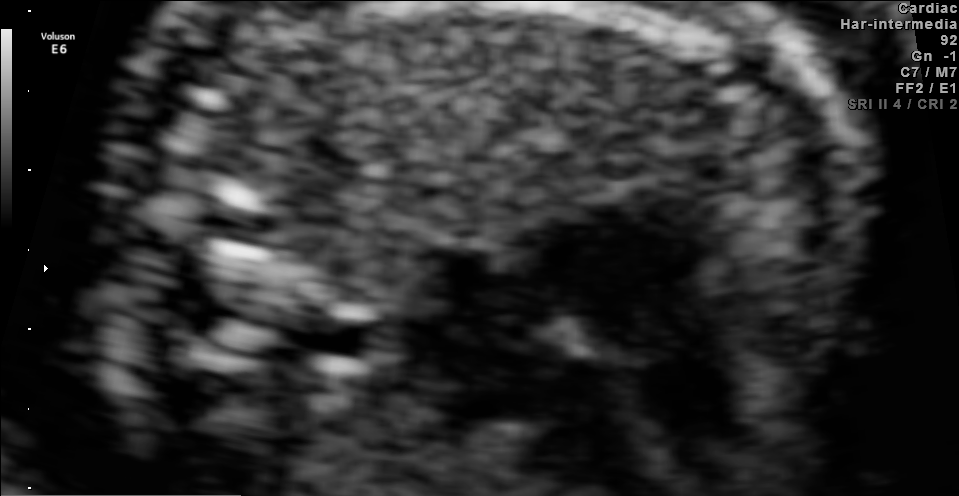

In [39]:
# 4. Open the image -- can use PyTorch but we will use PIL
img = Image.open(random_image_path)

# 5. Print image metadata with the image
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
# output img
img

## Plot an image with matplotlib

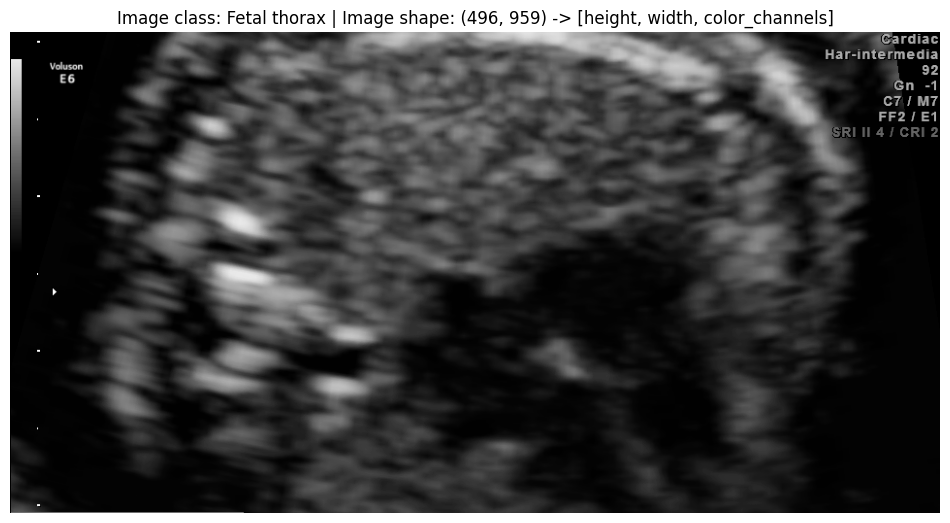

In [40]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# first step - turn image into array
img_as_array = np.array(img)

# plot an image with matplotlib
plt.figure(figsize=(12,7))
plt.imshow(img_as_array, cmap='gray')
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False); #turn off image axis

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,  70,  72, ...,   3,   3,   3],
       [  0,  70,  72, ...,   3,   3,   3],
       [  0, 112, 112, ...,   3,   3,   3]], dtype=uint8)
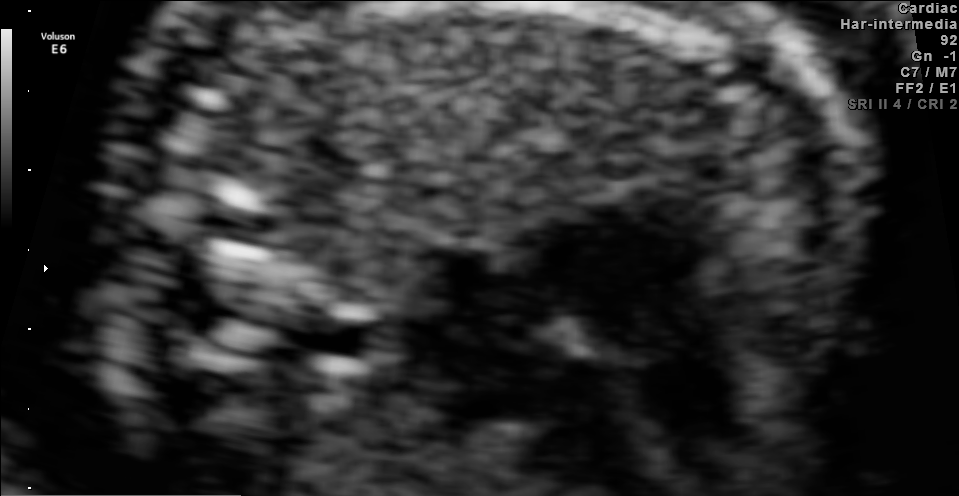

In [41]:
# another image
img_as_array

# 5. Pixel Sizes for each class - training data
* First we will look at the pixel sizes in kernel density histogram plots for each class in the training data.
* Then we will look at the pixel sizes in boxplots for each class in the training data.

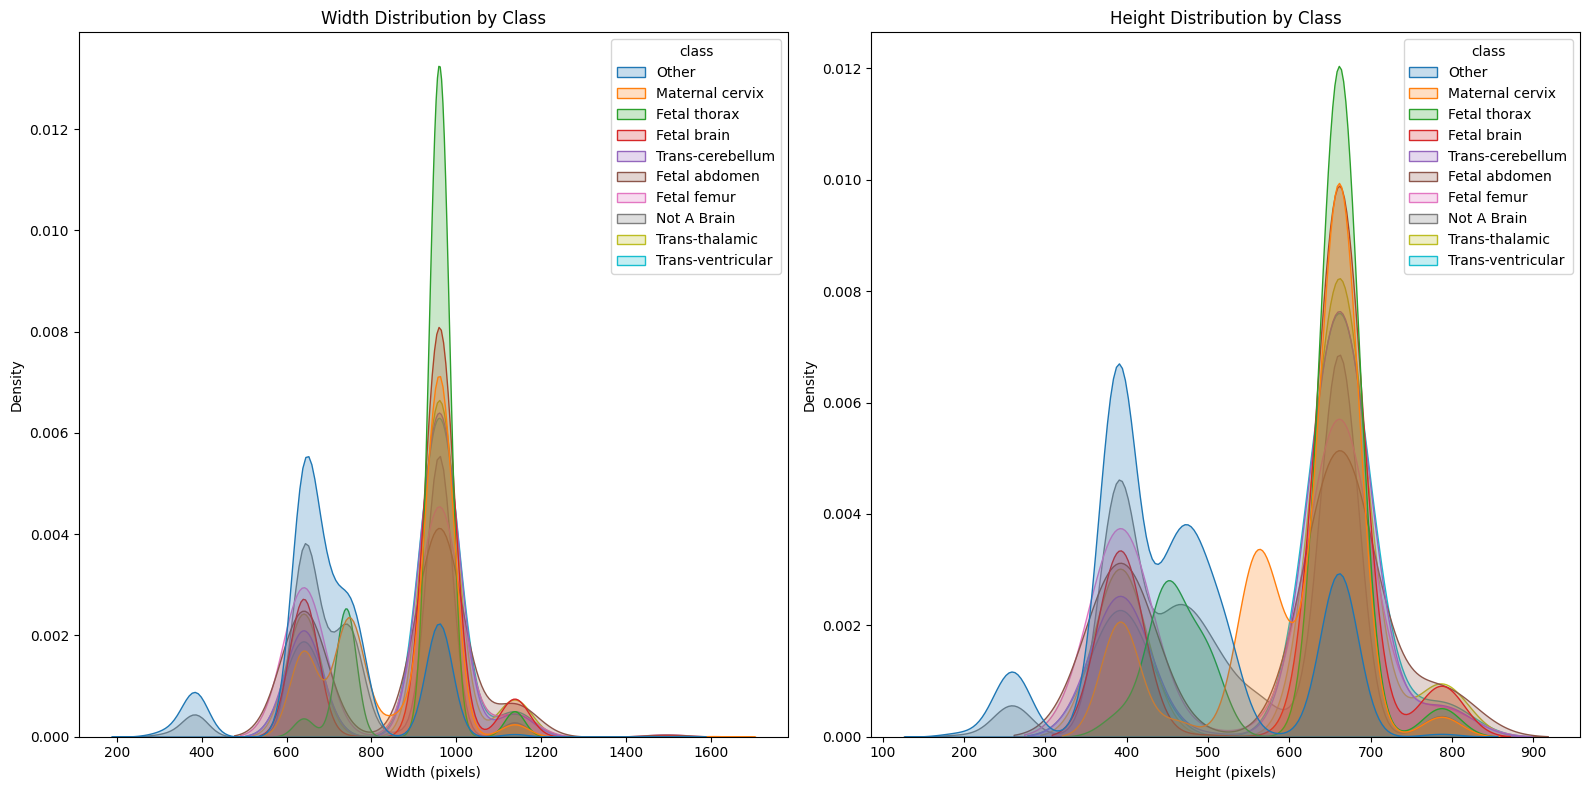

In [46]:
import os
from pathlib import Path
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_image_size_kde(train_dir):
    # List to store image sizes and their corresponding class
    data = []

    # Traverse through each class directory in train_dir
    for class_dir in os.listdir(train_dir):
        class_path = Path(train_dir) / class_dir
        if class_path.is_dir():
            for image_file in os.listdir(class_path):
                image_path = class_path / image_file
                try:
                    with Image.open(image_path) as img:
                        width, height = img.size
                        data.append({'class': class_dir, 'width': width, 'height': height})
                except Exception as e:
                    print(f"Error loading image {image_path}: {e}")

    # Convert the data to a DataFrame
    df = pd.DataFrame(data)

    # Plotting KDE histograms
    plt.figure(figsize=(16, 8))

    # Plot width KDE histograms
    plt.subplot(1, 2, 1)
    sns.kdeplot(data=df, x='width', hue='class', fill=True, common_norm=False)
    plt.title('Width Distribution by Class')
    plt.xlabel('Width (pixels)')
    plt.ylabel('Density')

    # Plot height KDE histograms
    plt.subplot(1, 2, 2)
    sns.kdeplot(data=df, x='height', hue='class', fill=True, common_norm=False)
    plt.title('Height Distribution by Class')
    plt.xlabel('Height (pixels)')
    plt.ylabel('Density')

    plt.tight_layout()
    plt.show()

# Call the function with the train_dir path
plot_image_size_kde('data/FETAL_PLANES_ZENODO/train_dir')


### Observations - Width (pixels)
* We can see for pixel width the density and width (pixels) is highest together for the fetal thorax images moreso than the other classes with a width of 1000 pixels.
* The next greatest pixel width and density is for the "other" class with a density of 0.006 and a pixel width of 600-800.
* Other than that for "width" pixels it seems the distribution is bi-modal with outliers at both ends of the spectrum.
### Observations - Height (pixels)
* The results are very similar to the findings above with fetal thorax having the highest height and density, however, the density has less spread than it did for the width of the images. Fetal thorax is closely followed by the other classes.
* The distribution of height pixels also has more variance and multiple distributions with varying pixel density whereas for the pixel width it was strictly a bimodal distribution.

### Why is this information important?
* We can use this information when performing image transformations and augmentations. It will also help us when considering the algorithm we utilize for prediction.
* The pixel size is also beneficial in helping us with kernel size, stride, padding and pooling in algorithms such as a CNN.

### Boxplots of the training data image pixels

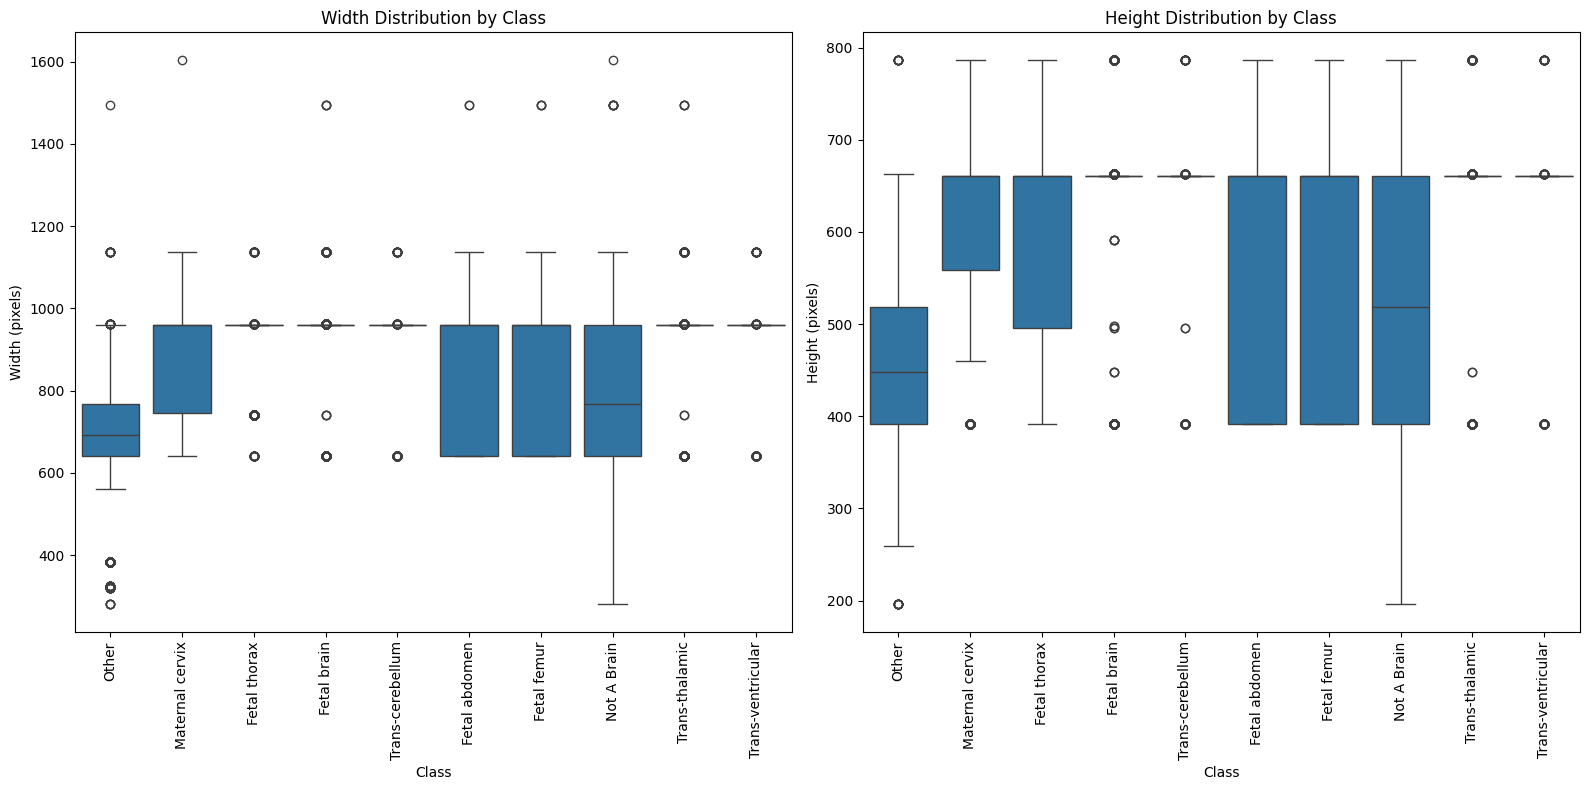

In [45]:
## function to make boxplots of the training images
def plot_image_size_boxplots(train_dir):
    # List to store image sizes and their corresponding class
    data = []

    # Traverse through each class directory in train_dir
    for class_dir in os.listdir(train_dir):
        class_path = Path(train_dir) / class_dir
        if class_path.is_dir():
            for image_file in os.listdir(class_path):
                image_path = class_path / image_file
                try:
                    with Image.open(image_path) as img:
                        width, height = img.size
                        data.append({'class': class_dir, 'width': width, 'height': height})
                except Exception as e:
                    print(f"Error loading image {image_path}: {e}")

    # Convert the data to a DataFrame
    df = pd.DataFrame(data)

    # Plotting box plots
    plt.figure(figsize=(16, 8))

    # Plot width box plots
    plt.subplot(1, 2, 1)
    sns.boxplot(data=df, x='class', y='width')
    plt.title('Width Distribution by Class')
    plt.xlabel('Class')
    plt.ylabel('Width (pixels)')
    plt.xticks(rotation=90)  # Rotate x labels for better readability

    # Plot height box plots
    plt.subplot(1, 2, 2)
    sns.boxplot(data=df, x='class', y='height')
    plt.title('Height Distribution by Class')
    plt.xlabel('Class')
    plt.ylabel('Height (pixels)')
    plt.xticks(rotation=90)  # Rotate x labels for better readability

    plt.tight_layout()
    plt.show()

# Call the function with the train_dir path
plot_image_size_boxplots('data/FETAL_PLANES_ZENODO/train_dir')


### Observations - width pixel distribution by class
* The boxplot allows us to see the information differently than the KDE histogram did.
* We can see the "Not A Brain" class has the most variability in pixel width.
* It appears that the classes "Not a Brain", "Fetal Femur", and "Fetal abdomen" all have similar distributions of pixel width for the 1st and 3rd quartiles.
* The other class seems to have the least variability in distribution of pixel width.
* All other classes seem to have a lot of overall variability in pixel width.

### Observations - width pixel distribution by class
* Pixel height distribution is similar to the width in that the 3 classes "Not a Brain", "Fetal femur", and "Fetal abdomen" all have similar distributions with "Not a Brain" having the widest distribution of pixel height.
* Fetal thorax and Maternal Cervix both have similar distributions of pixel height.
* In contrast to the "Other" category pixel width, we can see the pixel height is more variable for the "Other" class.



# 6. Transforming Data
* Before we can use our image data with PyTorch we need to:
1. Turn target data into tensors (in our case, numerical representation of our images)
2. Turn data into a `torch.utils.data`.Dataset and subsequently a torch.utils.data.DataLoader, we'll call these Dataset and DataLoader.

In [47]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

* We will turn the images from `.png` into tensors

You can do this a couple of ways:

1. `nn.Sequential()` - "scripting" the transforms - turning into a Python script.
2.`transforms.Compose` - Composes several transforms together. This transform does not support torchscript.

* Ultimately, transforms help you get your images ready to be used with a model/perform data augmentation.
* Then we would move the transformed data into a PyTorch DataLoader

In [48]:
## Write a transform for an image
data_transform = transforms.Compose([
    # resize images to 64x64 - computer vision size
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal (data augmentation) - probability of 0.5 (50% of time flip horizontal)
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()

])

In [49]:
#dtypes
data_transform(img).dtype

torch.float32

## Build function to plot transformed images

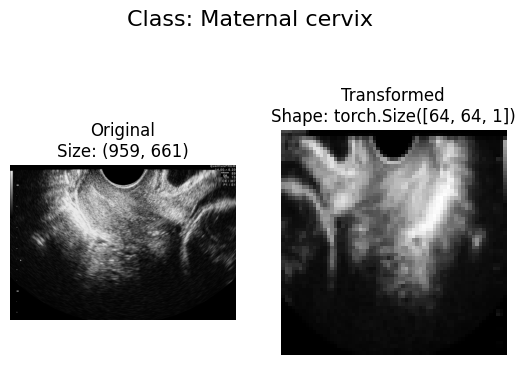

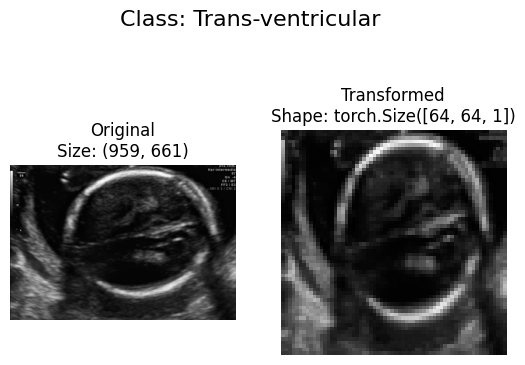

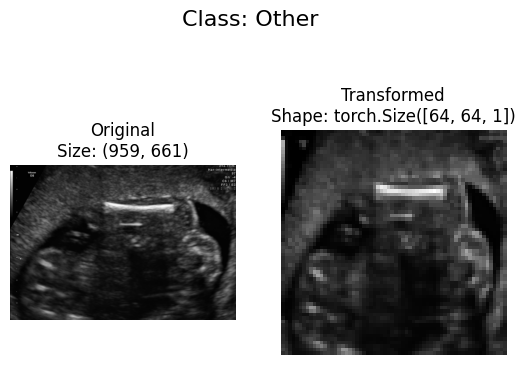

In [50]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=42):
  """
  Selects random images from a path of images and
  loads/transforms them then plots the original vs. the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  # loop through randomly sampled image_paths
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      #plot original image
      ax[0].imshow(f,cmap='gray')
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      # permute will change axis - color channels from first --> last
      # Changing default order from (C,H,W) --> (H,W,C)
      transformed_image = transform(f).permute(1, 2, 0) # note we will need to change shape for matplotlib - matplotlib prefers color channels last!
      ax[1].imshow(transformed_image,cmap='gray')
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)


# plot transformed images with function
# transform will = data_transform (above)
plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=None)# or 42 if no randomness

Observations of what we just did:
* We condensed the image size to 64,64 pixels.
* This "pixelates" the image.
* Thus, less information is encoded in a 64x64 image.
* Now a Model can compute faster on smaller size image but we may lose some of the detailed information (trade off).
* We can utilize some other pixelation condensing techniques, but this is usually standard.

# 7. Singular Value Decomposition (SVD)
* Even though we just compressed the images using PyTorch transformations, I would like to see how we can deconstruct and reconstruct an image using SVD as part of our EDA.

In [89]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random

# Define transform to resize and convert images to grayscale
data_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(),  # Convert to grayscale
    transforms.ToTensor()
])

# Custom dataset class -- we already created a torch custom datset class above but we will do this again
## so we can apply specific changes to perform SVD
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# Function to load images from a list of paths
def load_images(image_paths, transform, batch_size=1):
    dataset = CustomImageDataset(image_paths, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

# assign image path list and load images
image_paths = image_path_list
dataloader = load_images(image_paths, data_transform)


## Now perform SVD
* We will choose a random image from each class in the train directory and perform SVD on the image and reconstruct it.


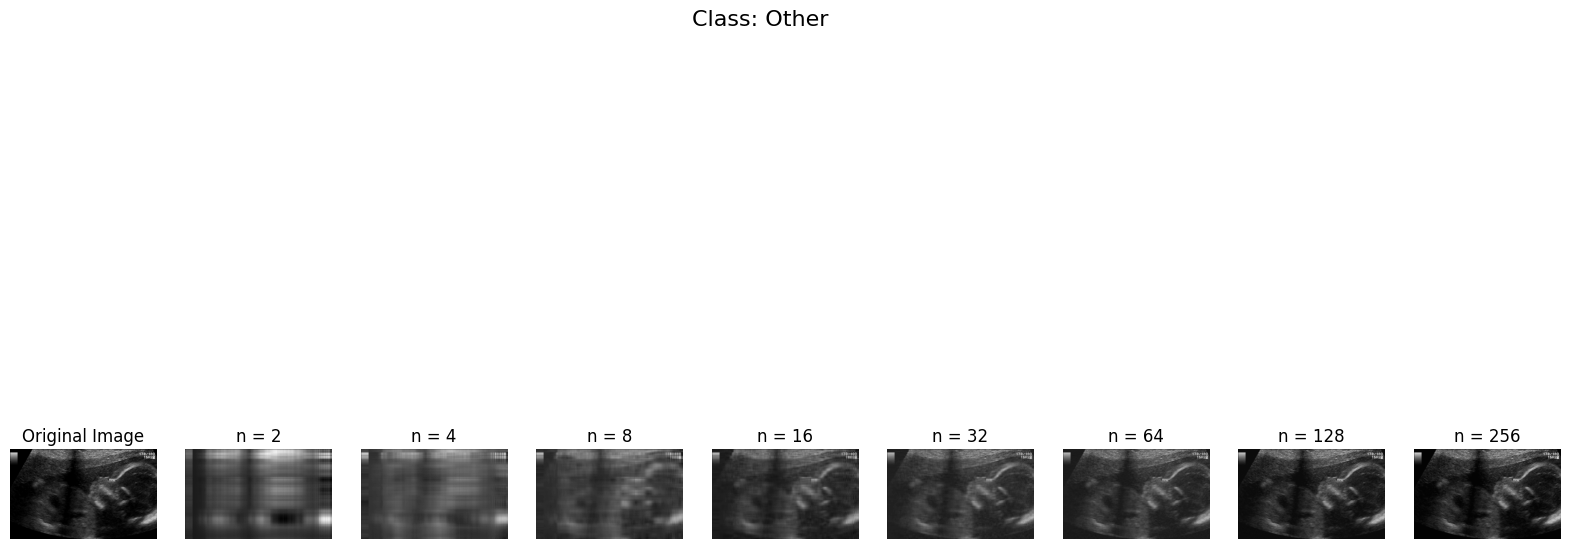

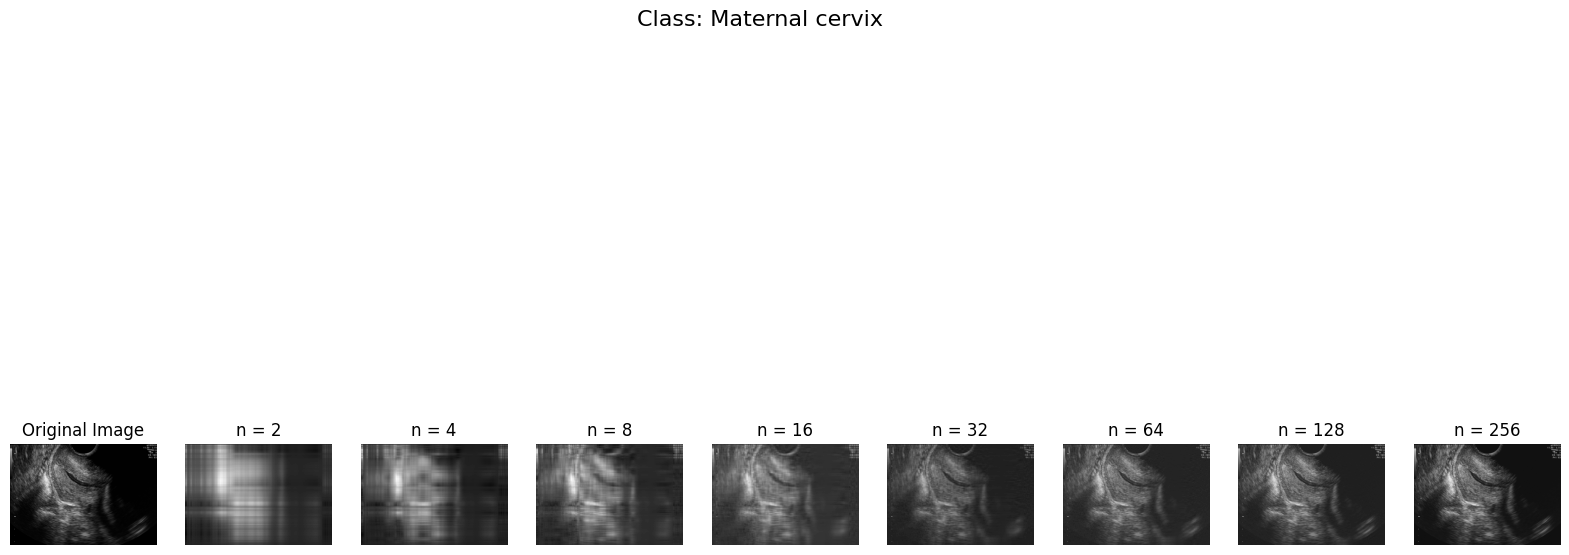

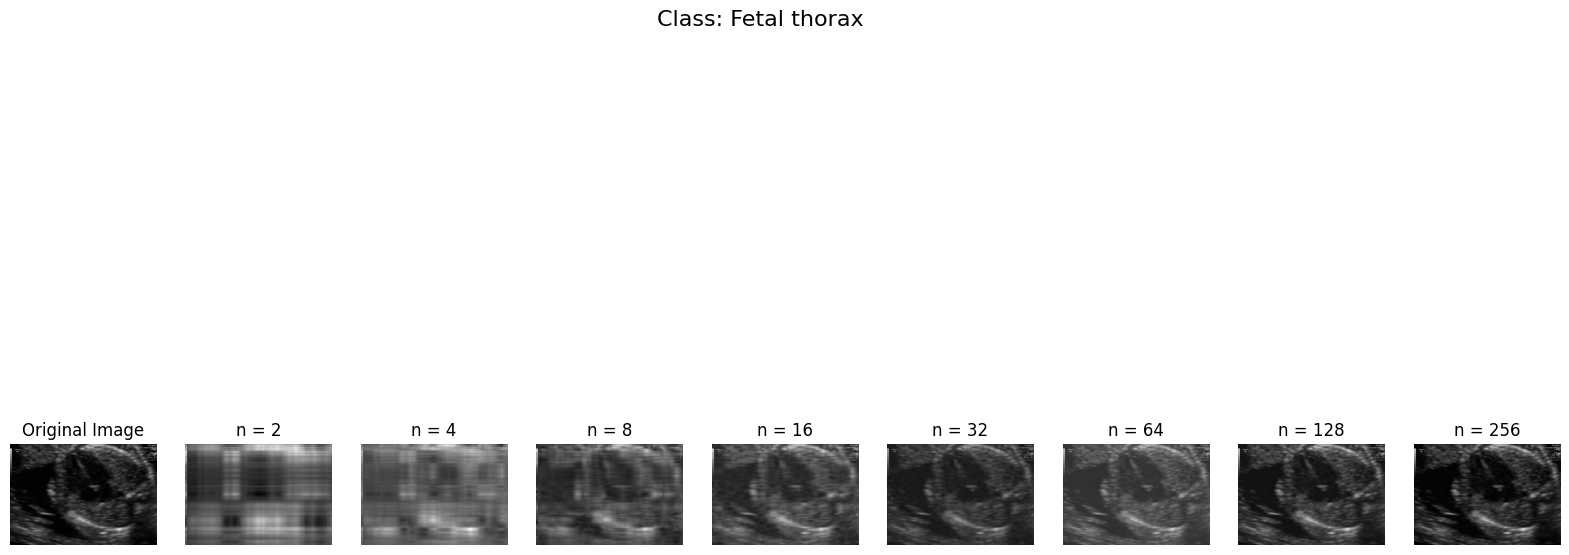

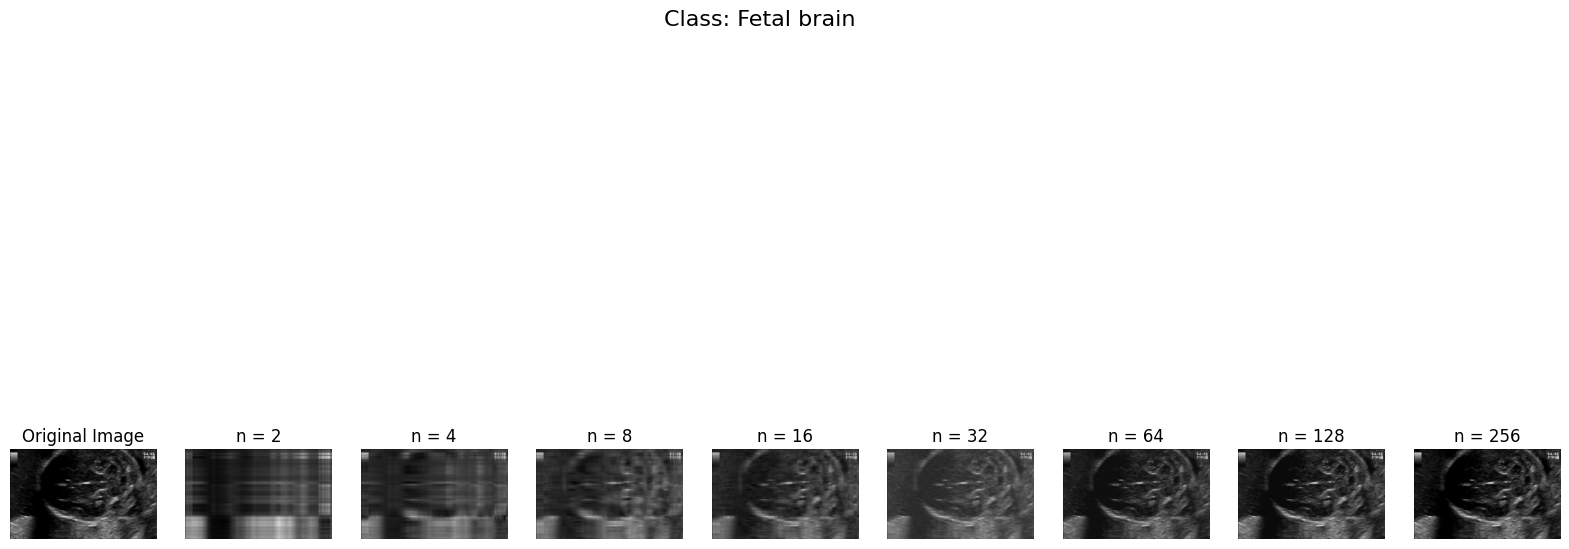

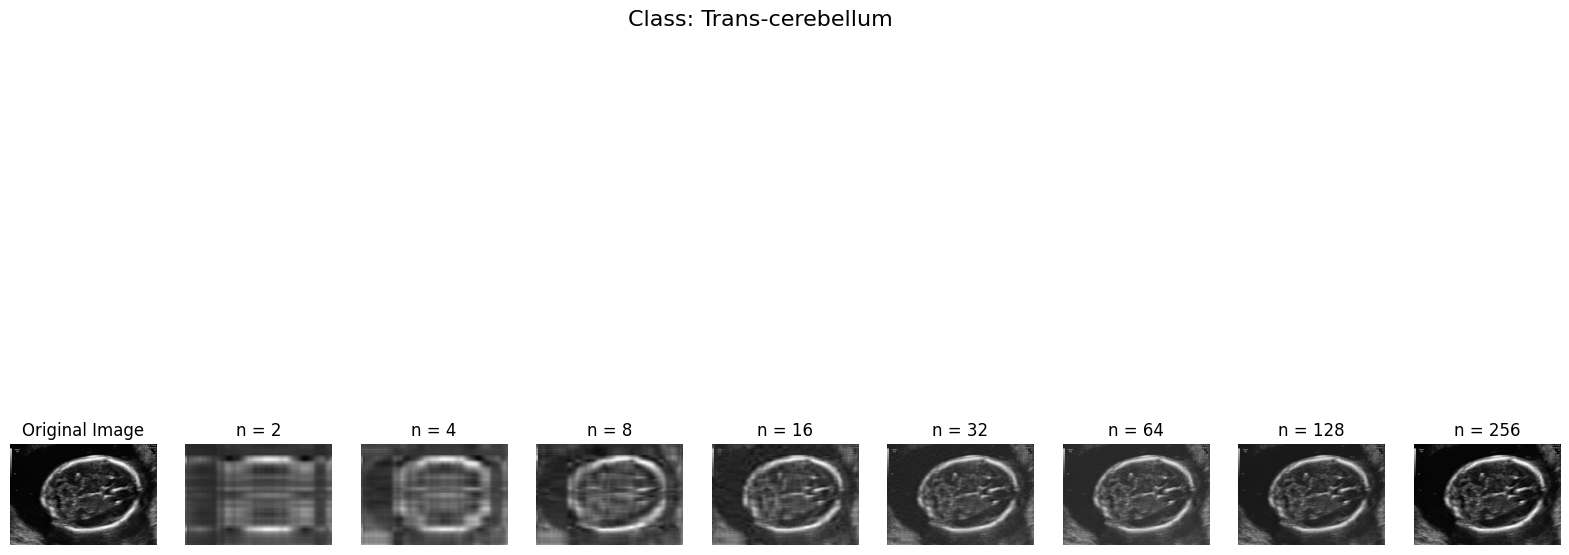

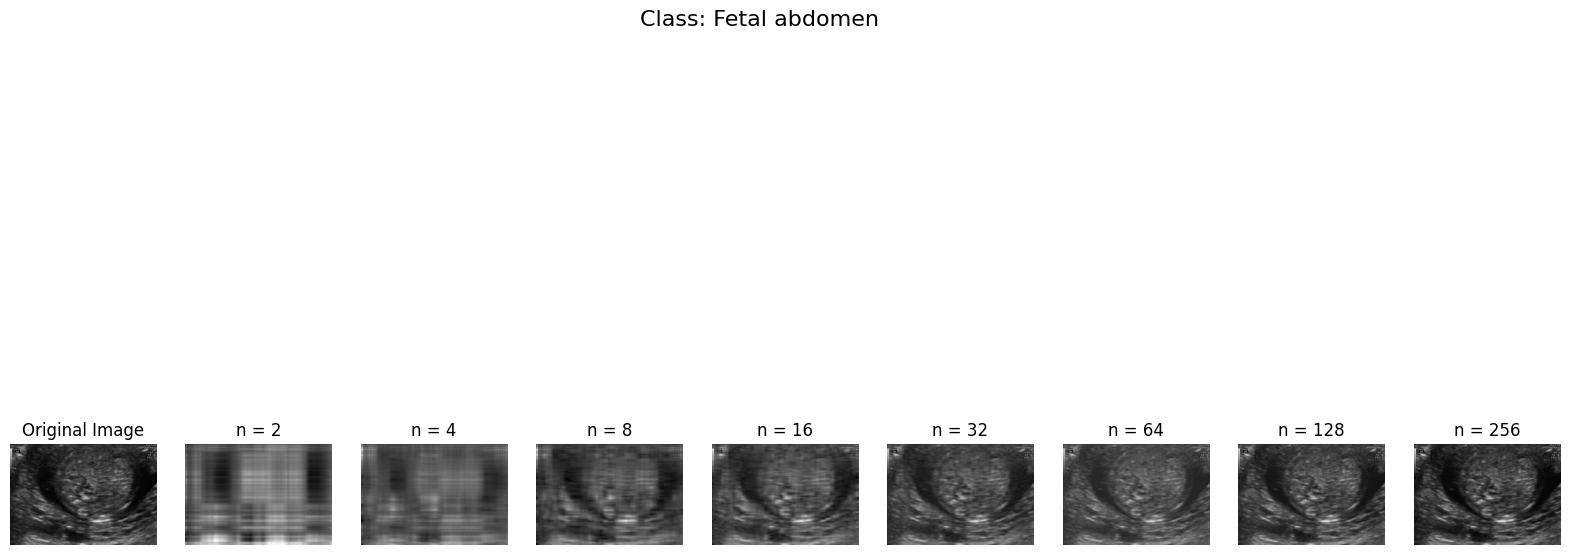

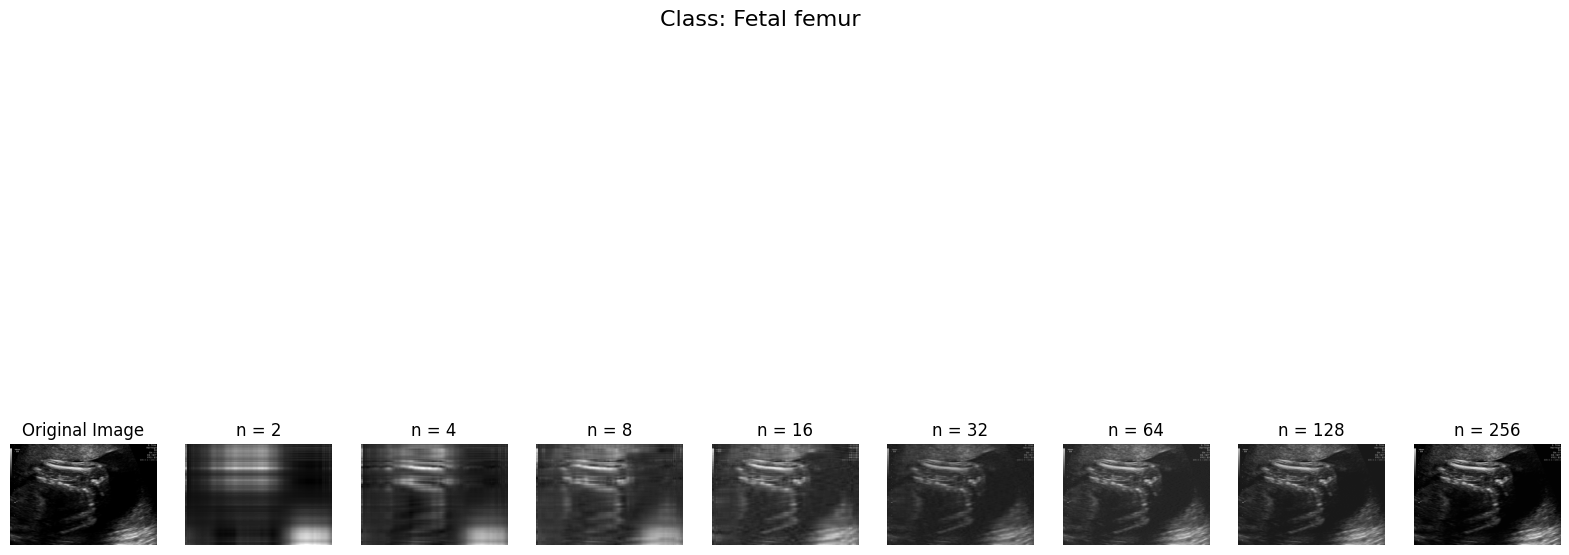

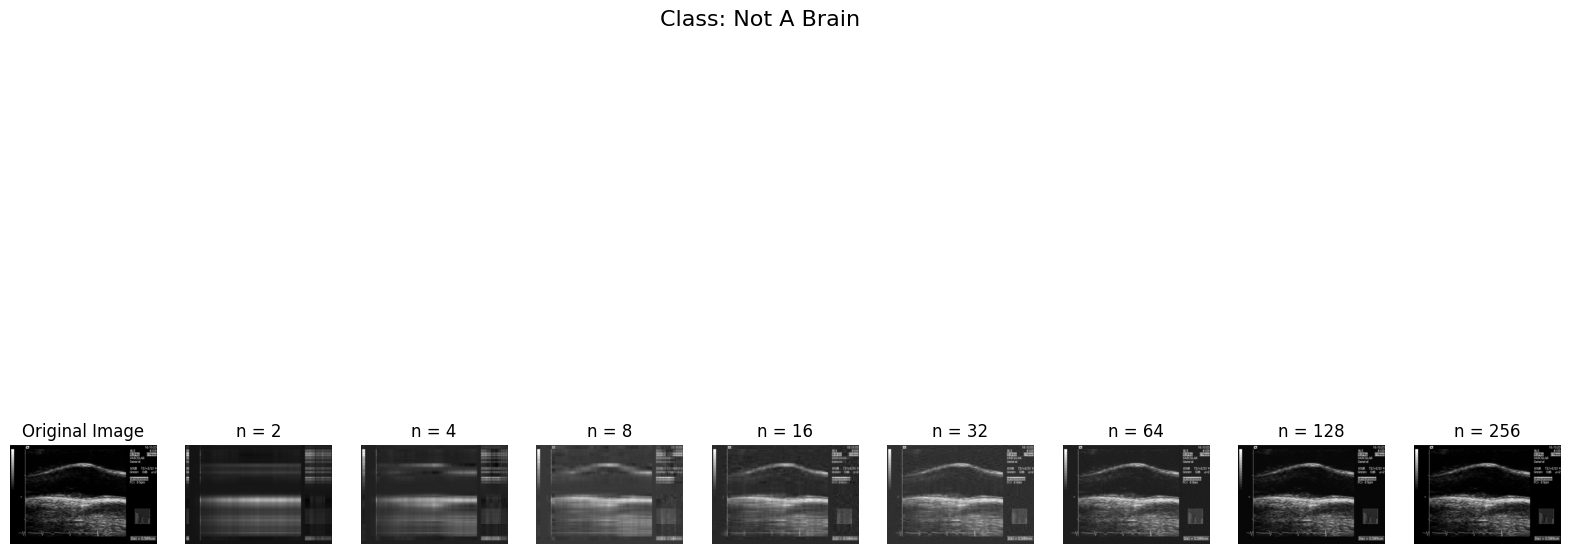

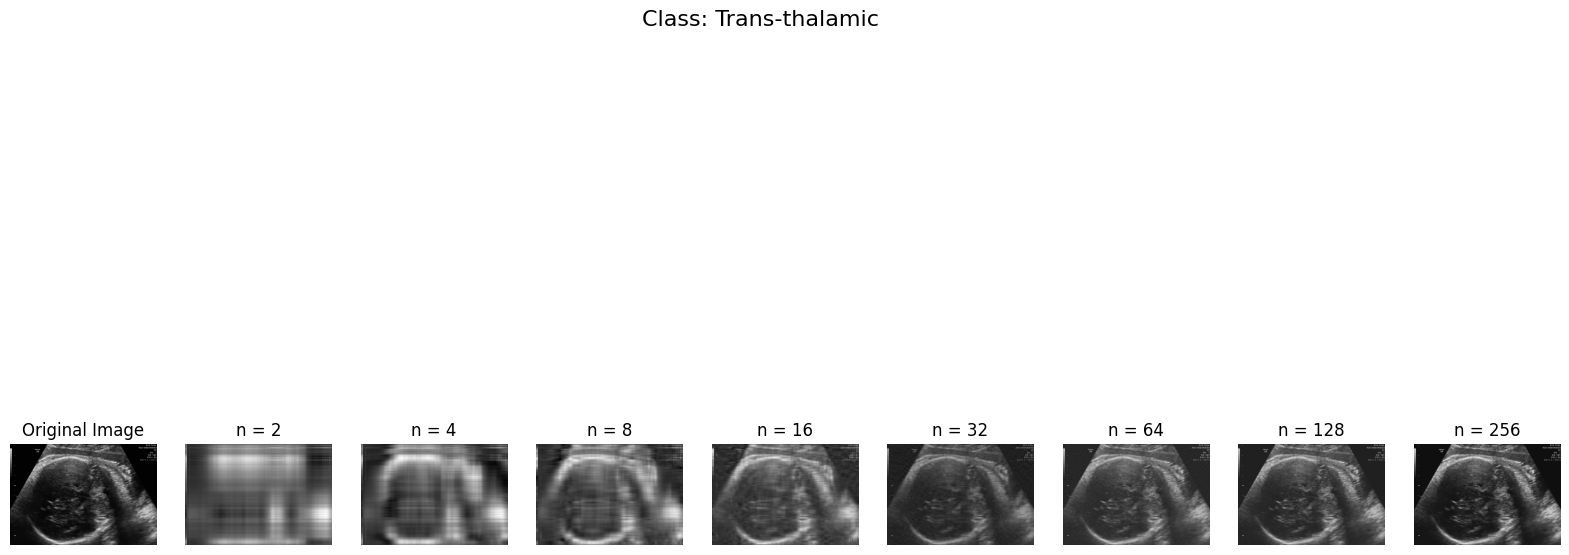

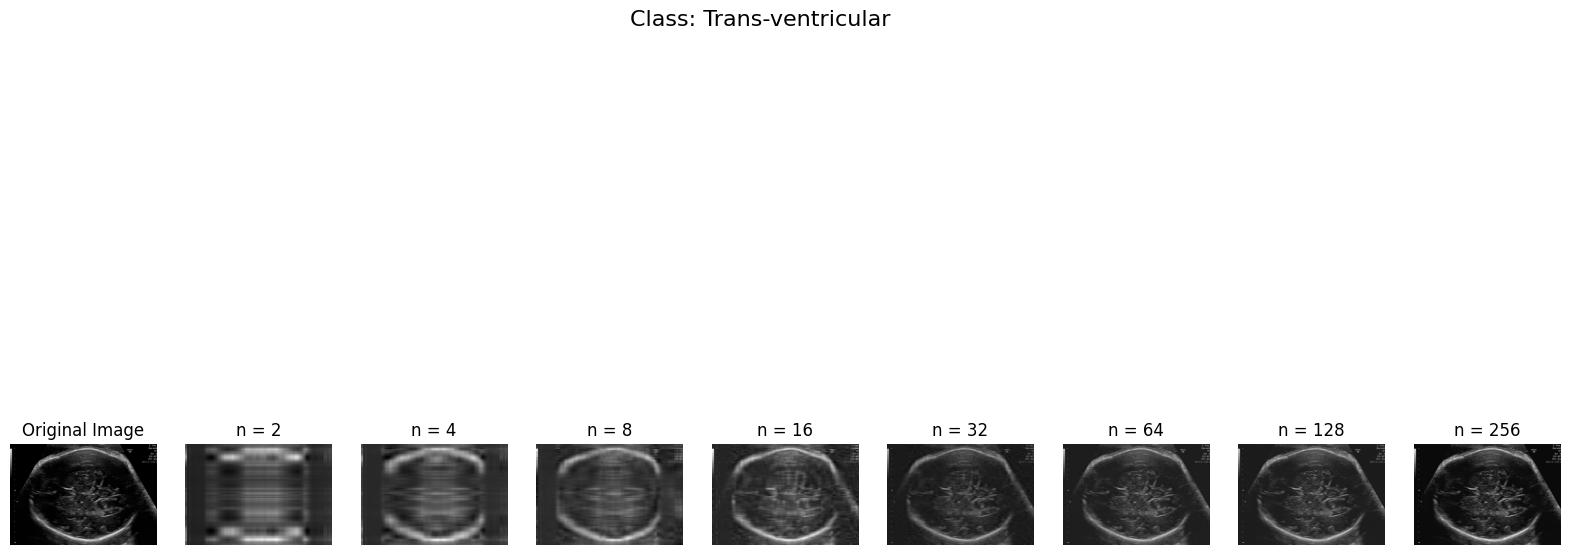

In [108]:
import os
import random

def plot_svd_reconstruction(image_tensor, class_name, n=3, n_components_list=[2, 4, 8, 16, 32, 64, 128, 256]):
    # Convert image tensor to numpy array
    img = image_tensor.squeeze().numpy()

    # Perform SVD
    U, sigma, V = np.linalg.svd(img, full_matrices=False)

    # Plot the original image
    plt.figure(figsize=(20,10))
    plt.subplot(1, len(n_components_list) + 1, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    # Incrementally reconstruct the image and plot
    for i, n in enumerate(n_components_list, 2):
        recon_img = np.dot(U[:, :n], np.dot(np.diag(sigma[:n]), V[:n, :]))

        plt.subplot(1, len(n_components_list) + 1, i)
        plt.imshow(recon_img, cmap='gray')
        plt.title(f'n = {n}')
        plt.axis('off')

    plt.suptitle(f"Class: {class_name}", fontsize=16)
    plt.show()

# List all class directories
class_dirs = [os.path.join(train_dir, d) for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

# Randomly select one image from each class
selected_images = {}
for class_dir in class_dirs:
    class_name = os.path.basename(class_dir)
    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith('.png')]
    selected_image = random.choice(images)
    selected_images[class_name] = selected_image

# Plot SVD reconstruction for selected images
for class_name, image_path in selected_images.items():
    image = Image.open(image_path)
    image_tensor = transforms.ToTensor()(image)
    plot_svd_reconstruction(image_tensor, class_name)


# Summary
* Exploratory Data Analysis showed us different aspects of this dataset to be more aware of as we now continue in the next notebook with image pre-processing and then finally training a deep learning model for our prediction of the class labels.
* A few important takeaways from this EDA analysis:
1. There is more training data (57%) than test data  > test data (42%)
2. Plane target class imbalance
  * "Other" dominates more than the other classes with more than 2x the number of image samples in the dataset than Fetal thorax and Maternal Cervix and almost 4x more image samples than fetal abdomen and fetal femur.
  * The next closest class in samples is fetal brain.
  * We may need to utilize data augmentation of the images using augmented transformations so that we do not create an overfitted model that generalizes poorly on unseen or validation data for the aformentioned image classes.
3. Brain_plane target classes
  * There are more "Brain_plane" class members for "Not A Brain" than for actual planes of the brain.
  * We may have to explore further with image data augmentation in the pre-processing steps to building our model.This certainly could overfit the model to predict "Not A Brain" rather than a plane of the brain.
4. Pixel density and width is highest together for the fetal thorax images moreso than the other classes with a width of 1000 pixels.
  * The next greatest pixel width and density is for the "other" class with a density of 0.006 and a pixel width of 600-800.
  * Other than that for "width" pixels it seems the distribution is bi-modal with outliers at both ends of the spectrum.
5. Pixel density and height
  * The results are very similar to the findings above with fetal thorax having the highest height and density, however, the density has less spread than it did for the width of the images. Fetal thorax is closely followed by the other classes.
  * The distribution of height pixels also has more variance and multiple distributions with varying pixel density whereas for the pixel width it was strictly a bimodal distribution.
6. Why is pixel information important?
  * We can use this information when performing image transformations and augmentations. It will also help us when considering the algorithm we utilize for prediction.
  * The pixel size is also beneficial in helping us with kernel size, stride, padding and pooling in algorithms such as a CNN.
7. The boxplot allows us to see the information differently than the KDE histogram did.
  * We can see the "Not A Brain" class has the most variability in pixel width.
  * It appears that the classes "Not a Brain", "Fetal Femur", and "Fetal abdomen" all have similar distributions of pixel width for the 1st and 3rd quartiles.
  * The other class seems to have the least variability in distribution of pixel width.
  * All other classes seem to have a lot of overall variability in pixel width.
8. Pixel height distribution is similar to the width in that the 3 classes "Not a Brain", "Fetal femur", and "Fetal abdomen" all have similar distributions with "Not a Brain" having the widest distribution of pixel height.
  * Fetal thorax and Maternal Cervix both have similar distributions of pixel height.
  * In contrast to the "Other" category pixel width, we can see the pixel height is more variable for the "Other" class.
9. Lastly, we were able to compare the Transforms using PyTorch to SVD. Both were able to compress the image pixels in a similar fashion and we were able to reconstruct the images using SVD. There are many other PyTorch transforms related to image cropping, resizing, rotation and position, color channels, and other mathematical operations that we could try but that would be an exercise worth taking on during image pre-processing and augmentation of the dataset.


# References
* ACOG, 2024. “Ultrasound Exams.” Accessed on 4/24/2024. Retrieved from: https://www.acog.org/womens-health/faqs/ultrasound-exams
* Ashkani Chenarlogh V, Ghelich Oghli M, Shabanzadeh A, et al. Fast and Accurate U-Net Model for Fetal Ultrasound Image Segmentation. Ultrasonic Imaging. 2022;44(1):25-38. doi:10.1177/01617346211069882
* BBC News, 2024. How AI could ‘save lives’ of pregnant women in Kenya. Link: https://www.youtube.com/watch?v=IZA-5cg3_WI
* Burgos-Artizzu XP, Coronado-Gutiérrez D, Valenzuela-Alcaraz B, Bonet-Carne E, Eixarch E, Crispi F, Gratacós E. Evaluation of deep convolutional neural networks for automatic classification of common maternal fetal ultrasound planes. Sci Rep. 2020 Jun 23;10(1):10200. doi: 10.1038/s41598-020-67076-5.
* G. Wang, X. Luo, R. Gu, S. Yang, Y. Qu, S. Zhai, Q. Zhao, K. Li, S. Zhang. (2023). PyMIC: A deep learning toolkit for annotation-efficient medical image segmentation. Computer Methods and Programs in Biomedicine (CMPB). February 2023, 107398. Github: https://github.com/HiLab-git/PyMIC
* Hoque, 2024. “How to Evaluate An Image Classification Model.” Accessed on 4/24/2024. Retrieved from: https://docs.clarifai.com/tutorials/how-to-evaluate-an-image-classification-model
* Kim ET, Singh K, Moran A, Armbruster D, Kozuki N. Obstetric ultrasound use in low and middle income countries: a narrative review. Reprod Health. 2018 Jul 20;15(1):129. doi: 10.1186/s12978-018-0571-y.
* Machine Learning Mastery – Object Recognition with Deep Learning: https://machinelearningmastery.com/object-recognition-with-deep-learning/
* Thomas L. A. van den Heuvel, Dagmar de Bruijn, Chris L. de Korte and Bram van Ginneken. Automated measurement of fetal head circumference using 2D ultrasound images. PloS one, 13.8 (2018): e0200412.
* Thomas L. A. van den Heuvel, Dagmar de Bruijn, Chris L. de Korte and Bram van Ginneken. Automated measurement of fetal head circumference using 2D ultrasound images [Data set]. Zenodo. http://doi.org/10.5281/zenodo.1322001
* V. Nagabotu and A. Namburu, Precise segmentation of fetal head in ultrasound images using improved U-Net model, ETRI Journal (2023), 1–12, DOI 10.4218/etrij.2023-0057.
* Yang et al, 2022. “A new approach to automatic measure fetal head circumference in ultrasound images using convolutional neural networks.” Computers in Biology and Medicine. Link: https://www.sciencedirect.com/science/article/abs/pii/S0010482522005674?via%3Dihub
